# Inference Testing
The list of files for inference testing have clear errors/missing levees from the original train/test/val data areas, shown in the notebook marked "coordinates_TIF_selection"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import rasterio
from tqdm import tqdm

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.modeling.inference import get_preds_targets
from levee_hunter.modeling.modeling_utils import prune_skeleton

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

from shapely.geometry import LineString
from skimage.measure import label
from skimage import measure

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/ucapmgb/levee-hunter/levee_hunte

In [2]:
# Load the original levees file
original_levees_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/levees.gpkg")

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Load the trained model
# trained_model
model_path = "/share/gpu5/ucapmgb/levee-hunter/models/Unet-13_384_invert_fold5.pth"
# load saved model
model.load_state_dict(torch.load(model_path))
model.eval()

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

# Dataset

In [6]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/masks',
    transform=None,
    weighted=True,
    )

# Create DataLoader
val_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

### Predictions

In [7]:
# Get predictions
preds, targets = get_preds_targets(model=model, val_loader=val_loader, device=device)

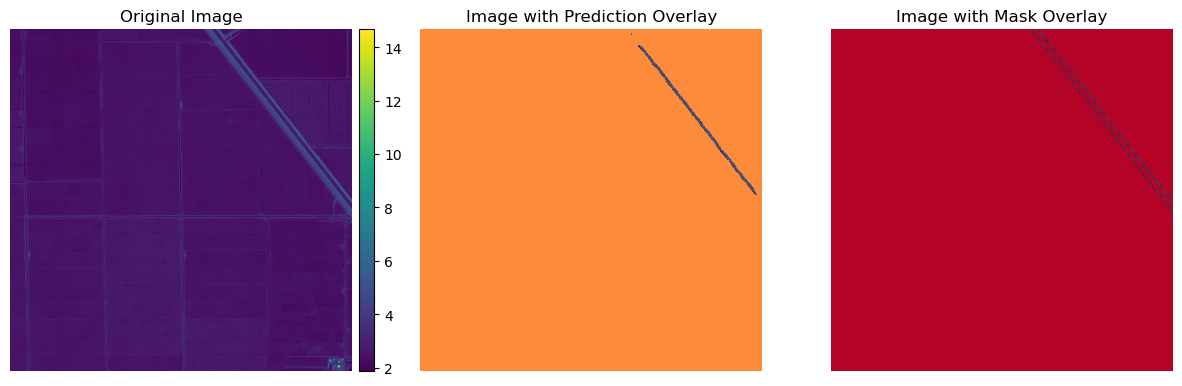

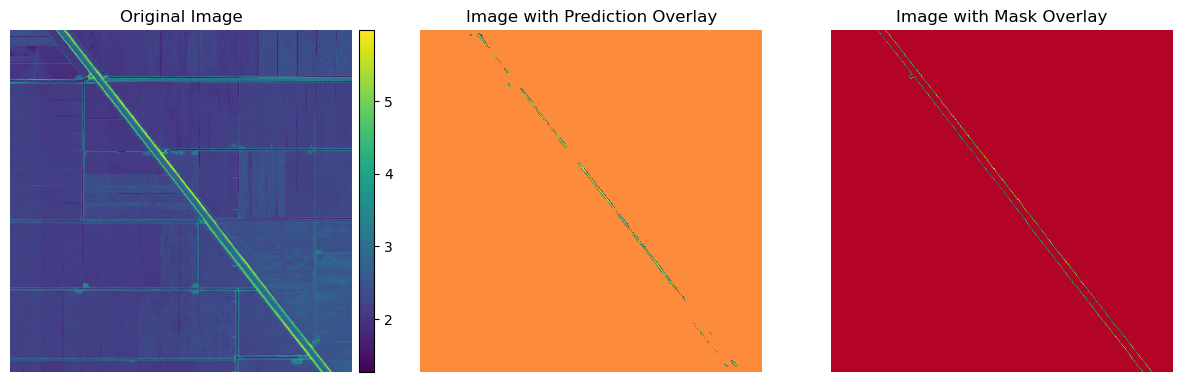

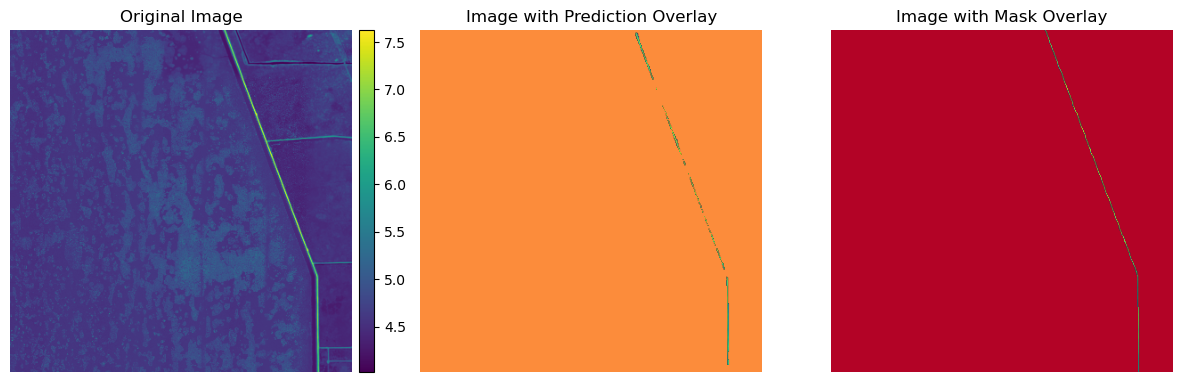

In [8]:
from levee_hunter.plotting import plot
from levee_hunter.modeling.inference import infer

for ix in range(3):
    sample_image, sample_mask, *_ = dataset[ix]
    prediction = infer(model=model, image=sample_image, device=device, apply_sigmoid=True, threshold=0.5)
    
    plot(
        image=sample_image, 
        mask=sample_mask, 
        pred=prediction, 
        plot_types=['image', 'image_pred_overlay', 'image_mask_overlay'], 
        powernorm_threshold=30
        )

### Inference
- Skeletonize predictions
- Output images with new levees in them

In [9]:
def single_prediction_to_lines(
    pred, image_path,
    threshold=0.5, crs="EPSG:4269",
    min_length=3, debug_plots=False
):
    # 1. logits→probs
    if isinstance(pred, torch.Tensor):
        if pred.min()<0 or pred.max()>1:
            pred = torch.sigmoid(pred)
        pred = pred.detach().cpu().numpy()

    # 2. squeeze channel
    if pred.ndim==3 and pred.shape[0]==1:
        pred = pred[0]

    # 3. threshold → 1px mask
    binary = (pred>threshold).astype(np.uint8)

    # 4. prune skeleton
    binary = prune_skeleton(binary, min_branch_length=min_length)
    if debug_plots:
        plt.figure(figsize=(8,8))
        plt.title("Pruned Skeleton")
        plt.imshow(binary, cmap="gray")
        plt.show()
    # 4.1. label
    labeled = label(binary)

    # 5. load transform
    with rasterio.open(image_path) as src:
        transform = src.transform

    # 6. Extract ordered lines
    rows = []
    
    # Use contour tracing instead of region traversal
    contours = measure.find_contours(binary, level=0.5)

    # Filter out tiny ones
    contours = [c for c in contours if len(c) >= min_length]
    if not contours:
        # nothing to output
        return gpd.GeoDataFrame(columns=["geometry","image_path"], geometry="geometry", crs=crs)

    for contour in contours:
        # If it’s a closed loop (start and end nearly identical), drop the last point
        if np.allclose(contour[0], contour[-1], atol=1e-3):
            contour = contour[:-1]

        # Convert pixel (row, col) → world (x, y)
        geo_coords = [
            rasterio.transform.xy(transform, y, x, offset="center")
            for (y, x) in contour
        ]

        # Convert to LineString
        line = LineString(geo_coords)
        # Add to rows
        rows.append({
            "geometry": line,
            "image_path": image_path,
        })

    # debug overlay
    if debug_plots:
        img = rioxarray.open_rasterio(image_path)[0]
        fig,ax=plt.subplots(1,1,figsize=(8,8))
        img.plot.imshow(ax=ax,cmap="gray")
        gpd.GeoDataFrame(rows, crs=crs).to_crs(img.rio.crs).plot(
            ax=ax, color='red', linewidth=1
        )
        plt.title("Extracted Linesegments")
        plt.show()

    if not rows:
        return gpd.GeoDataFrame(columns=["geometry", "image_path"], geometry="geometry", crs=crs)
    else:
        return gpd.GeoDataFrame(rows, geometry="geometry", crs=crs)



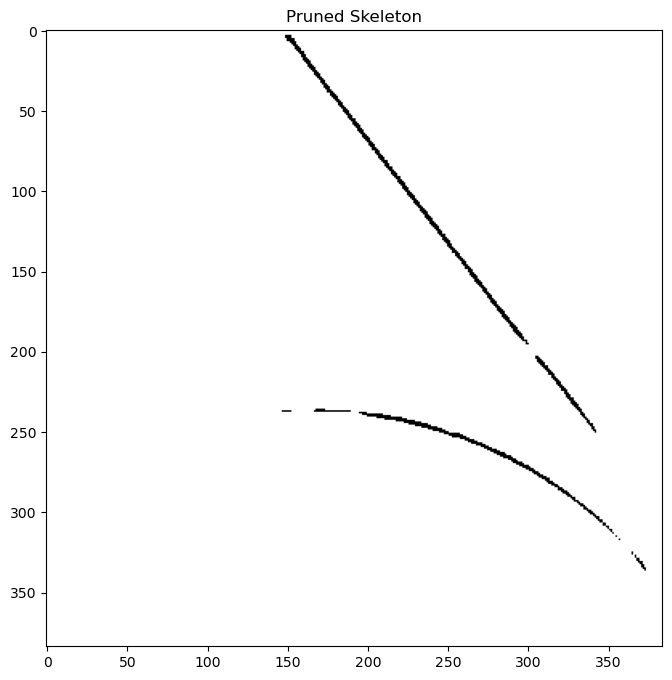

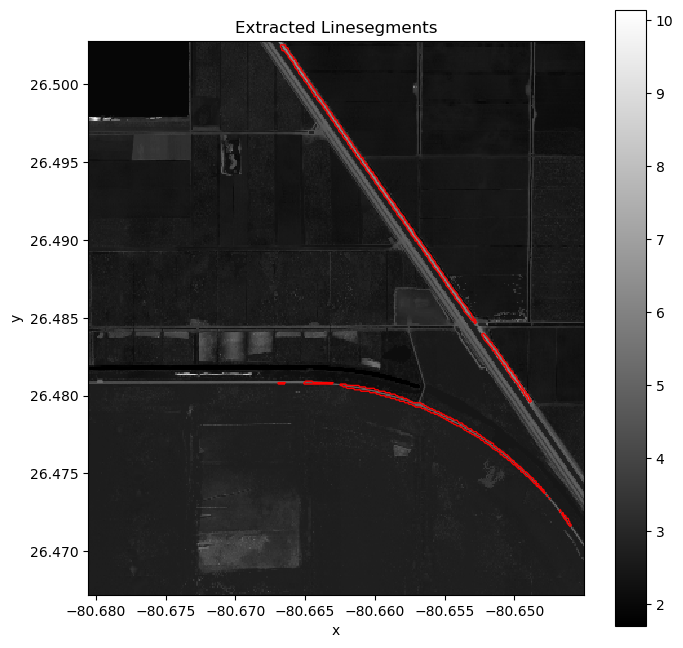

In [10]:
gdf = single_prediction_to_lines(
    pred=preds[5],
    image_path=dataset.img_paths[5],
    threshold=0.5,
    crs="EPSG:4269",
    min_length=2,
    debug_plots=True
)

In [11]:
gdf

geometry  \
0  LINESTRING (-80.65269 26.48468, -80.65273 26.4...   
1  LINESTRING (-80.6488 26.47958, -80.6488 26.479...   
2  LINESTRING (-80.66296 26.48079, -80.66301 26.4...   
3  LINESTRING (-80.66639 26.48079, -80.66644 26.4...   
4  LINESTRING (-80.64778 26.47375, -80.64782 26.4...   
5  LINESTRING (-80.64759 26.47356, -80.64764 26.4...   
6  LINESTRING (-80.64741 26.47338, -80.64745 26.4...   
7  LINESTRING (-80.64667 26.47255, -80.64667 26.4...   
8  LINESTRING (-80.64593 26.47162, -80.64593 26.4...   

                                          image_path  
0  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
1  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
2  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
3  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
4  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
5  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
6  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
7  /share/gpu5/ucapmgb/levee-hunter/data/processe...  
8  /share/gpu5/ucapmgb/levee-hunter/data/processe...

In [12]:
from tqdm import tqdm

def batch_predictions_to_lines(
    predictions,
    image_paths,
    threshold=0.5,
    crs="EPSG:4269",
    min_length=3,
    debug_every_n=None
):
    """
    Loop over lists of model outputs + image paths,
    extract LineStrings via single_prediction_to_lines, and
    concatenate into one GeoDataFrame (with image_path column).
    """
    all_gdfs = []
    for i, (pred, img_path) in enumerate(
            tqdm(zip(predictions, image_paths), total=len(predictions),
                 desc="Batch Extract Lines")):
        debug = (debug_every_n is not None) and (i % debug_every_n == 0)
        gdf = single_prediction_to_lines(
            pred=pred,
            image_path=img_path,
            threshold=threshold,
            crs=crs,
            min_length=min_length,
            debug_plots=debug
        )
        if not gdf.empty:
            all_gdfs.append(gdf)

    if all_gdfs:
        return gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True), crs=crs)
    else:
        return print("No valid lines found in predictions.")


In [13]:
predicted_levees_gdf = batch_predictions_to_lines(
    predictions=preds,
    image_paths=dataset.img_paths,
    threshold=0.5,
    min_length=2,
    debug_every_n=None,   # show debug plots every 10 tiles
)

Batch Extract Lines: 100%|██████████| 1316/1316 [16:58<00:00,  1.29it/s]


### Comparison to original levee file

In [14]:
# Function to find and plot predictions that don't align well with original levees
def mismatched_predictions(predicted_gdf, original_gdf):
   # Buffer the original levees to check for overlap
   buffered_originals = original_gdf.geometry.buffer(50)  # 50 meters buffer
   
   # Find predicted levees that don't intersect with buffered originals
   non_matching = []
   for idx, pred_row in predicted_gdf.iterrows():
      # Check if this predicted levee intersects with any original levee
      intersects = False
      for buff in buffered_originals:
         if pred_row.geometry.intersects(buff):
            intersects = True
            break
      
      if not intersects:
         non_matching.append(idx)
   
   print(f"Found {len(non_matching)} predicted levees that don't match with originals")
   
   
# Call the function
mismatched_predictions(predicted_levees_gdf, original_levees_gdf)

/tmp/ipykernel_9695/381455432.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_originals = original_gdf.geometry.buffer(50)  # 50 meters buffer


Found 0 predicted levees that don't match with originals


In [15]:
# Function to find and plot predictions that align well with original levees
def find_matching_predictions(predicted_gdf, original_gdf):
   # Ensure both GeoDataFrames have the same CRS
   if predicted_gdf.crs != original_gdf.crs:
      predicted_gdf = predicted_gdf.to_crs(original_gdf.crs)

   # Check what value is needed for 25m buffer in this crs
   # Check the CRS units to understand what buffer value to use
   print(f"CRS: {original_levees_gdf.crs}")

   # For testing, we'll check what 25 meters would be in the current CRS units
   # If the CRS is in degrees, we need to convert meters to approximate degrees
   # Assuming we're near the equator, 1 degree is approximately 111,000 meters

   if original_levees_gdf.crs.is_geographic:
      # Convert 25 meters to degrees (approximate conversion)
      buffer_value = 25 / 111000  # ~0.00023 degrees
      print(f"Using buffer of {buffer_value} degrees (approximately 25 meters)")
   else:
      # If CRS is projected (in meters), use 25 directly
      buffer_value = 25
      print(f"Using buffer of {buffer_value} meters")

   # Buffer the original levees to check for overlap
   buffered_originals = original_gdf.geometry.buffer(buffer_value)  # 25 meters buffer
   # Find predicted levees that intersect with buffered originals
   matching = []
   for idx, pred_row in predicted_gdf.iterrows():
      # Check if this predicted levee intersects with any original levee
      intersects = False
      for buff in buffered_originals:
         if pred_row.geometry.intersects(buff):
            intersects = True
            break
      if intersects:
         matching.append(idx)
   print(f"Found {len(matching)} predicted levees that match with originals")
   return matching
   
# Call the function
matching = find_matching_predictions(predicted_levees_gdf, original_levees_gdf)

CRS: EPSG:4269
Using buffer of 0.00022522522522522523 degrees (approximately 25 meters)


/tmp/ipykernel_9695/102483902.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_originals = original_gdf.geometry.buffer(buffer_value)  # 25 meters buffer


Found 4429 predicted levees that match with originals


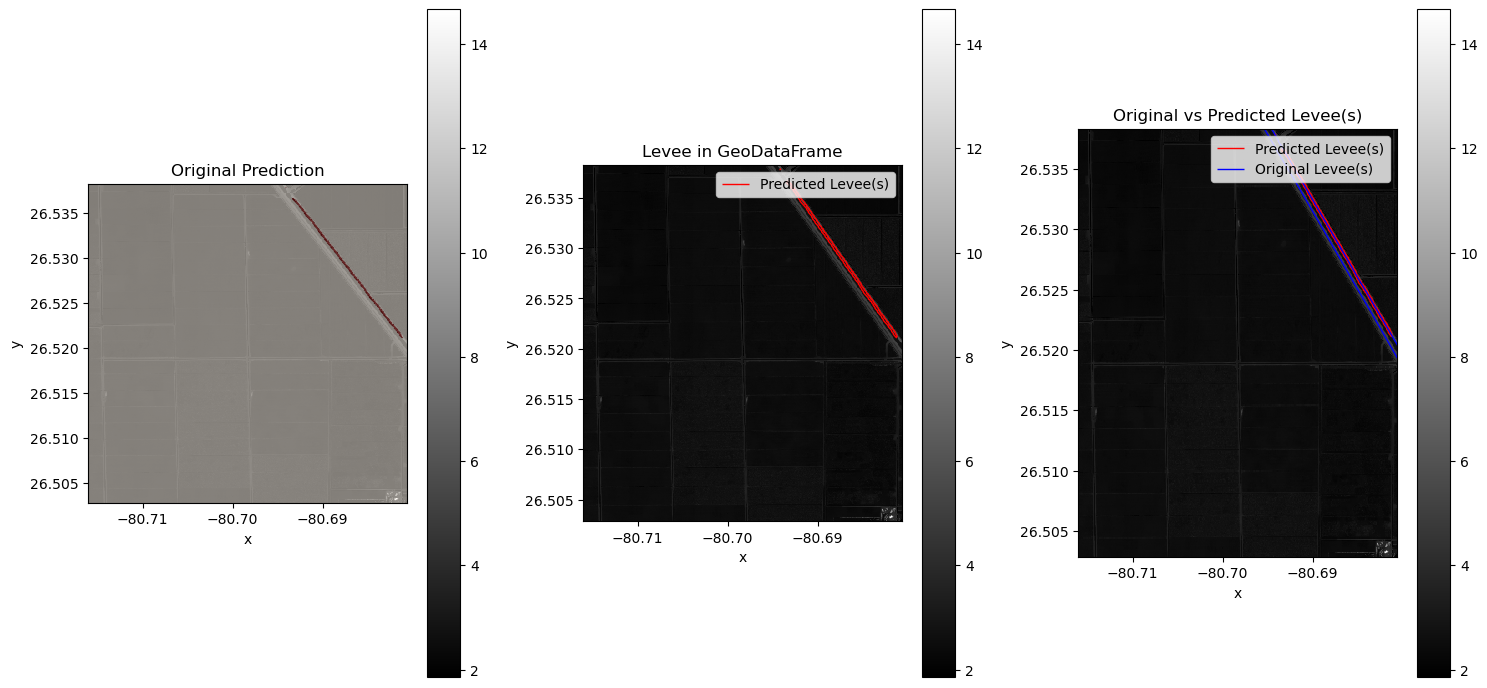

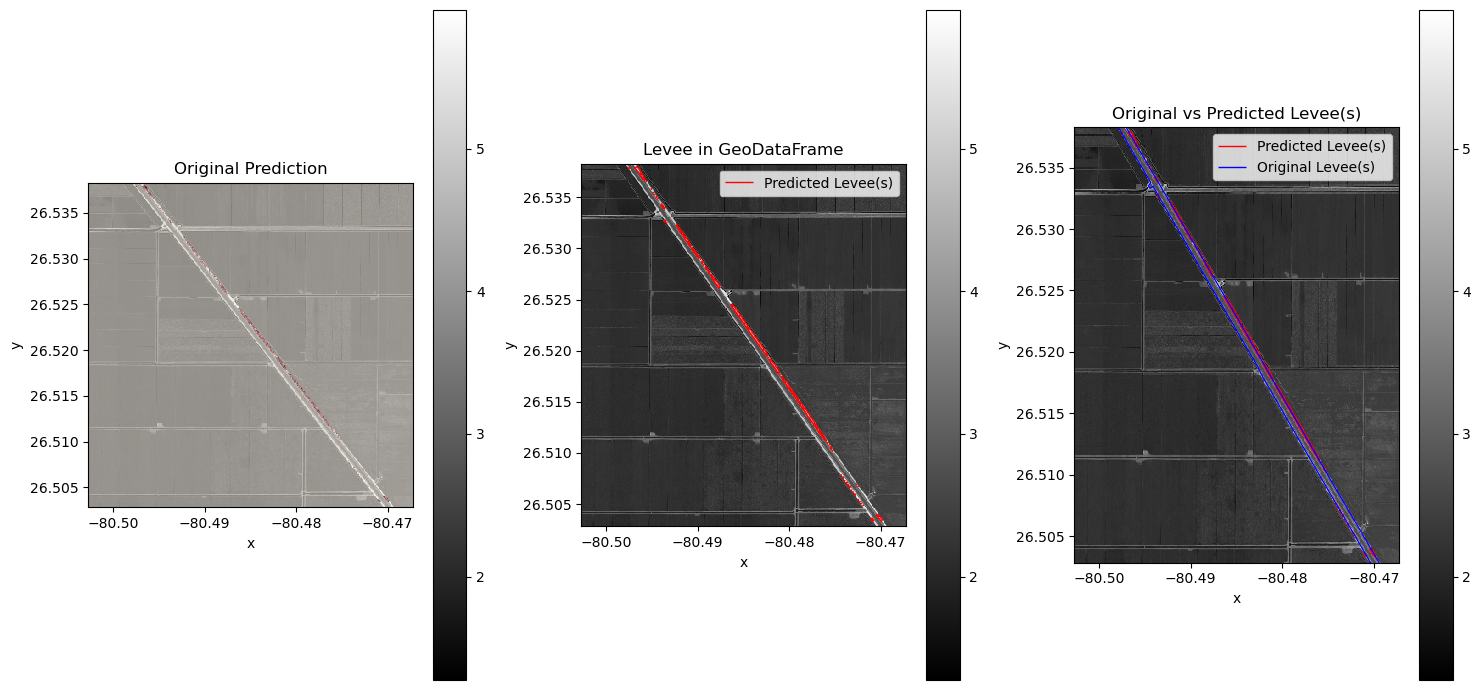

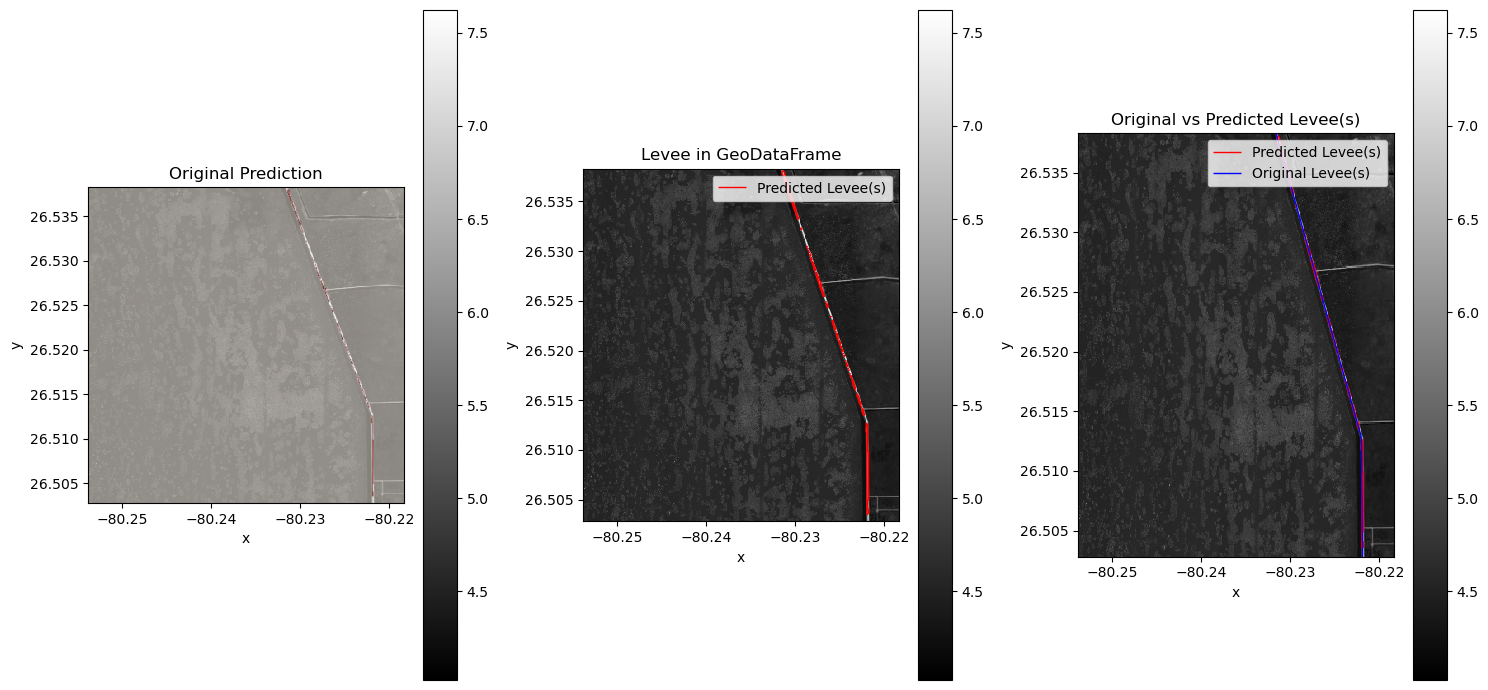

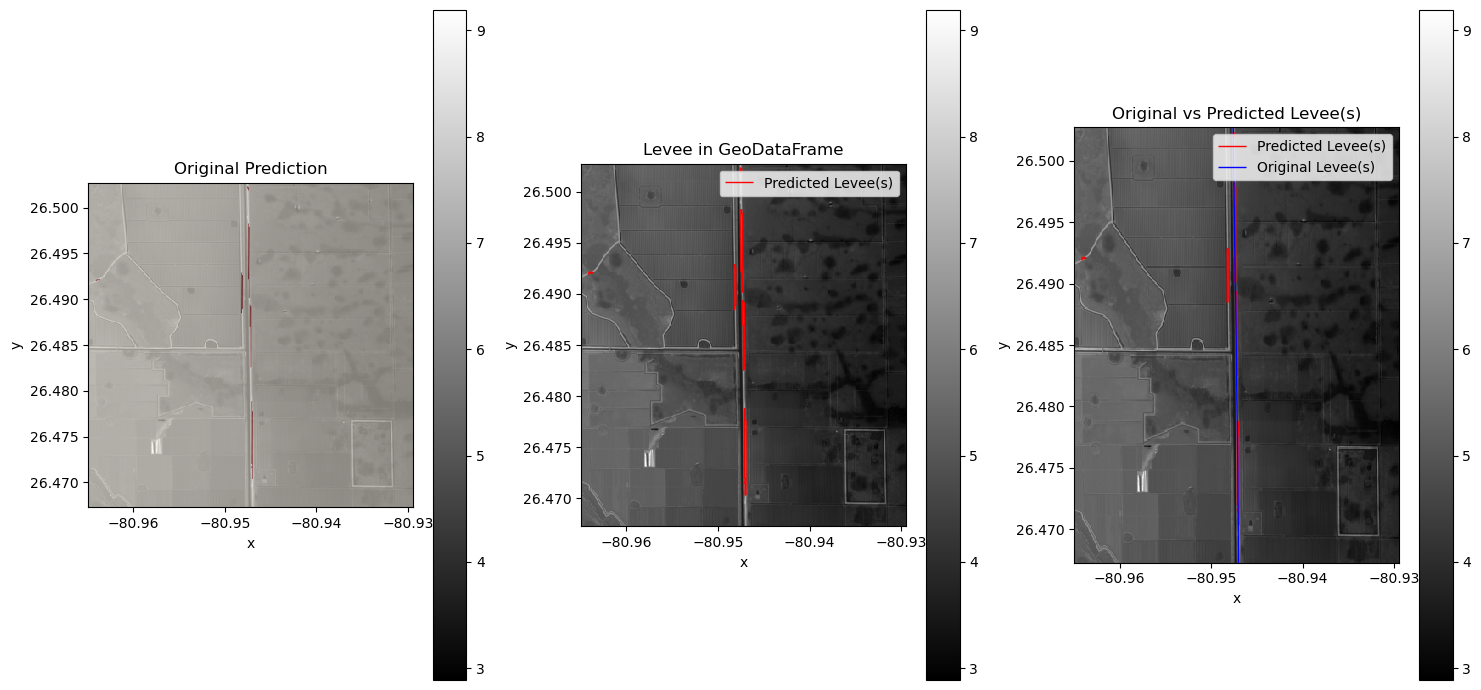

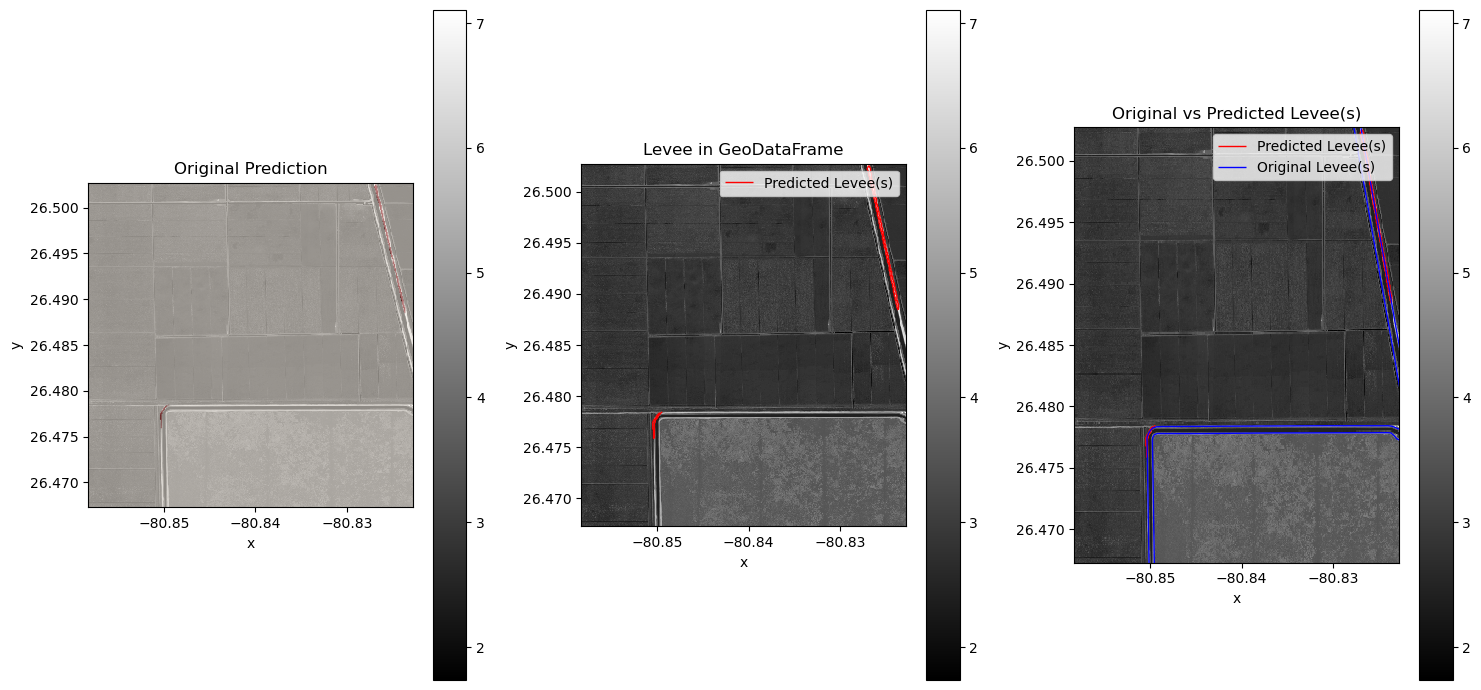

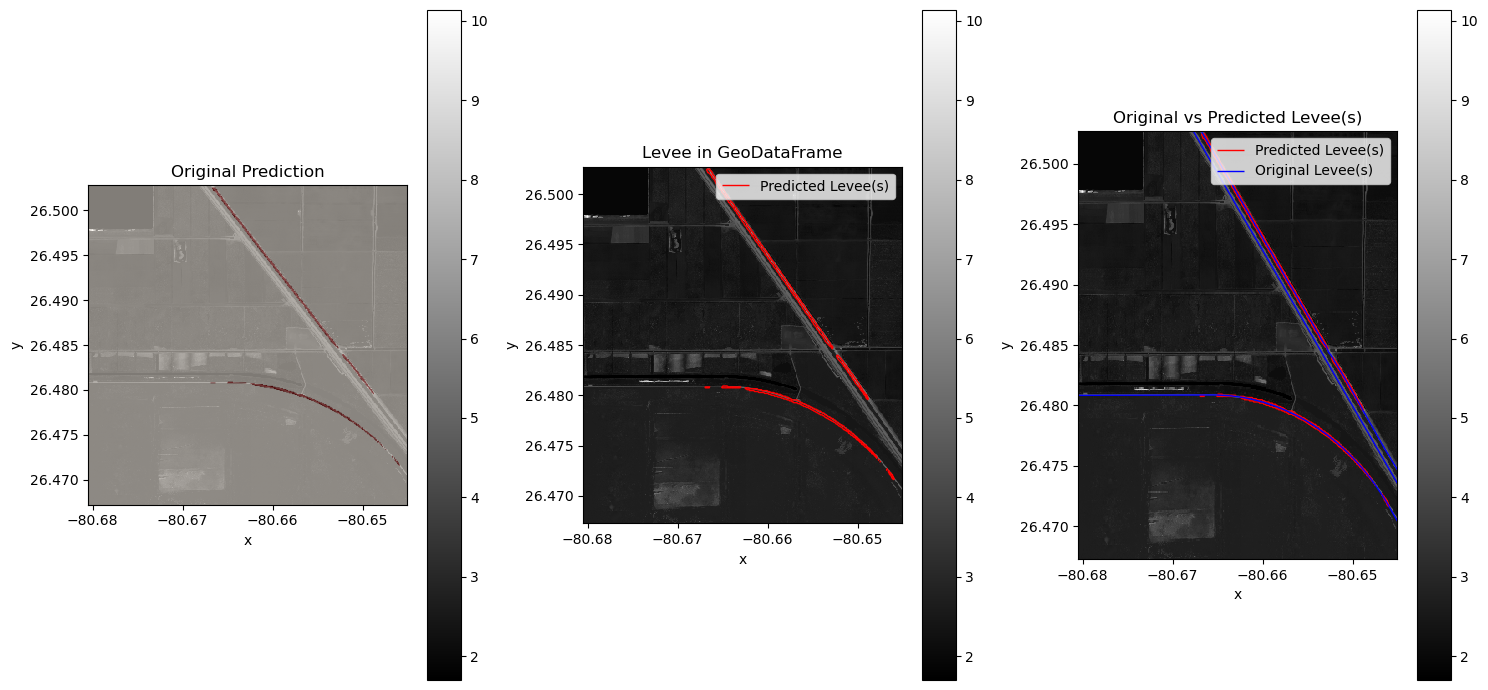

In [16]:
def plot_matching(matching, dataset, pred_gdf, original_gdf, n=3):
   # Sample n matching predictions
   if len(matching) > n:
      sample_indices = np.random.choice(matching, n, replace=False)
   else:
      sample_indices = matching
   
   # Plot n_samples prediction alongside the original data
   for i, idx in enumerate(sample_indices):
      # Get the corresponding predicted levee
      img_idx = i 
      img_filename = dataset.img_paths[img_idx]
      sample_image, sample_mask, *_ = dataset[img_idx]
      prediction = infer(model=model, image=sample_image, device=device, apply_sigmoid=True, threshold=0.5)
      pred_mask = prediction.squeeze()

      # Filter predicted GDF for this image
      pred_for_img = pred_gdf[pred_gdf["image_path"] == img_filename]

      # Load the image with rioxarray to preserve geospatial information
      img_data = rioxarray.open_rasterio(img_filename)
      pred_for_img = pred_for_img.to_crs(img_data.rio.crs)
      
      # Get the extent of the image
      left, bottom, right, top = (
         img_data.x.min().item(),
         img_data.y.min().item(),
         img_data.x.max().item(),
         img_data.y.max().item()
      )
      
      # Create a figure with two subplots
      fig, axes = plt.subplots(1, 3, figsize=(15, 7))
      
      for ax in axes:
         ax.set_xlim([left, right])
         ax.set_ylim([bottom, top])
         ax.set_aspect('equal')   
      
      # Plot the image and the predicted levee from the tensor array
      img_data[0].plot.imshow(ax=axes[0], cmap='gray')
      axes[0].set_title(f'Original Prediction')
      # Plot the prediction as an overlay on the image
      axes[0].imshow(pred_mask, alpha=0.5, cmap='OrRd', extent=[left, right, bottom, top])
      
      # Plot the image on the left w/ predicted levee
      img_data[0].plot.imshow(ax=axes[1], cmap='gray')
      axes[1].set_title(f'Levee in GeoDataFrame')
      pred_for_img.plot(ax=axes[1], color='red', linewidth=1, label='Predicted Levee(s)')
      axes[1].legend()

      # Plot the original and predicted levees on the right
      img_data[0].plot.imshow(ax=axes[2], cmap='gray')
      axes[2].set_title('Original vs Predicted Levee(s)')
      pred_for_img.plot(ax=axes[2], color='red', linewidth=1, label='Predicted Levee(s)')
      original_gdf.plot(ax=axes[2], color='blue', linewidth=1, label='Original Levee(s)')
      axes[2].legend()

      plt.tight_layout()
      plt.show()

# Call the function
plot_matching(matching, dataset, predicted_levees_gdf, original_levees_gdf, n=6)
